In [1]:
#Basic imports
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import joblib

import helpers as helpers

# Data Processing

In [2]:
# Import data
data1 = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
data2 = pd.read_excel('data2.xlsx', 'Sheet1', header=0)

In [3]:
data2['Date of birth'] = pd.to_datetime(data2['Date of birth'].astype(str), format='%d/%m/%Y')
data2['Date of MRI scan'] = pd.to_datetime(data2['Date of MRI scan'].astype(str), format='%Y-%m-%d', errors='ignore')
data2['Age'] = (data2['Date of MRI scan'] - data2['Date of birth'])/ np.timedelta64(1, 'Y')

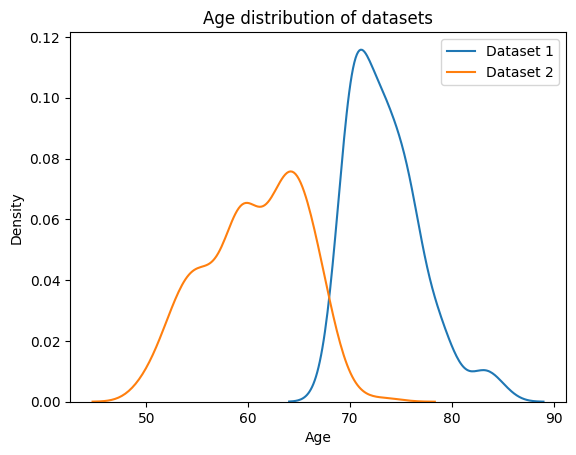

Dataset1 : (133 samples, 335 features)
Dataset2 : (232 samples, 175 features)


In [4]:
sns.kdeplot(
    data1,
    x='Age',
    label='Dataset 1'
).set_title("Age distribution of datasets")

sns.kdeplot(
    data2,
    x='Age',
    label='Dataset 2'
)

plt.legend()
plt.show()

print(f'Dataset1 : ({data1.shape[0]} samples, {data1.shape[1]} features)')
print(f'Dataset2 : ({data2.shape[0]} samples, {data2.shape[1]} features)')

## Format dataset 1

In [5]:
data_train1, data_test1, y_train1, y_test1 = train_test_split(data1.drop(['Age'], axis=1), data1['Age'], test_size=0.3, random_state=2)
x_train1, del_col1, mean_train1, std_train1 = helpers.clean_data(1, data_train1)
x_test1, _, _, _ = helpers.clean_data(1, data_test1, del_col1, mean_train1, std_train1)

In [6]:
x_train1 = x_train1.reset_index(drop=True)
x_test1 = x_test1.reset_index(drop=True)
y_train1 = pd.DataFrame(data=y_train1, columns=['Age']).reset_index(drop=True)
y_test1 = pd.DataFrame(data=y_test1, columns=['Age']).reset_index(drop=True)

## Format dataset 2

In [7]:
data_train2, data_test2, y_train2, y_test2 = train_test_split(data2.drop(['Age'], axis=1), data2['Age'], test_size=0.3, random_state=2)
x_train2, del_col2, mean_train2, std_train2 = helpers.clean_data(2, data_train2)
x_test2, _, _, _ = helpers.clean_data(2, data_test2, del_col2, mean_train2, std_train2)

In [8]:
x_train2 = x_train2.reset_index(drop=True)
x_test2 = x_test2.reset_index(drop=True)
y_train2 = pd.DataFrame(data=y_train2, columns=['Age']).reset_index(drop=True)
y_test2 = pd.DataFrame(data=y_test2, columns=['Age']).reset_index(drop=True)

## Select dataset

In [9]:
i_data = 1

if (i_data == 1):
    x_train = x_train1
    x_test = x_test1
    y_train = y_train1
    y_test = y_test1
elif (i_data == 2):
    x_train = x_train2
    x_test = x_test2
    y_train = y_train2
    y_test = y_test2

### Models

In [10]:
from sklearn import svm
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Create grids for search parameters
param_grid_svm = [
    {'clf__C': np.logspace(-3, 3, 10), 'clf__kernel': ['linear']},
    {'clf__C': np.logspace(-3, 3, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
]

param_grid_elastic = {
    'clf__alpha': np.logspace(-10,7,25),
    'clf__l1_ratio': np.append(np.logspace(-10,0,20), 0)
}

param_grid_adaboost = {
    'clf__n_estimators': np.arange(1, 200, 20),
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

param_grid_forest = {
    'clf__n_estimators': np.arange(10, 100, 20),
    'clf__max_depth': np.arange(1, 20)
}

param_grid_knn = {
    'clf__n_neighbors': np.arange(1, 20)
}


# Create models grid search
model_svr = helpers.model_gs(
    svm.SVR(),
    param_grid_svm
)

model_elastic = helpers.model_gs(
    ElasticNet(max_iter=5000),
    param_grid_elastic
)

model_adaboost = helpers.model_gs(
    AdaBoostRegressor(random_state = 123),
    param_grid_adaboost
)

model_forest = helpers.model_gs(
    RandomForestRegressor(),
    param_grid_forest
)

model_knn = helpers.model_gs(
    KNeighborsRegressor(),
    param_grid_knn
)

# Create models list
models = {
    "SVR": model_svr,
    "ElasticNet": model_elastic,
    "AdaBoost": model_adaboost,
    "RandomForest": model_forest,
    "KNN": model_knn
}


# PLS

In [11]:
# PLS Regression
pls_train, pls_test = helpers.PLS_regression(x_train, x_test, y_train, y_test, n_components = 20)

### Standardize

In [12]:
pls_train_scaled, pls_test_scaled = helpers.standardize(pls_train, pls_test)

### Filter MI Score

In [13]:
pls_train_scaled, pls_test_scaled = helpers.filter_mi_scores(pls_train_scaled, pls_test_scaled, y_train, 0)

<AxesSubplot: >

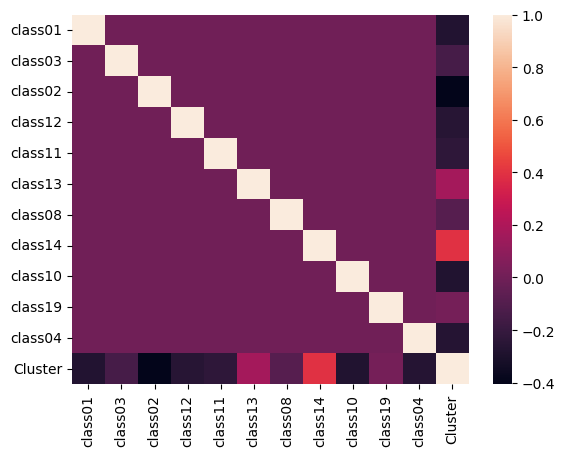

In [53]:
sns.heatmap(pls_train_scaled.corr())

<AxesSubplot: >

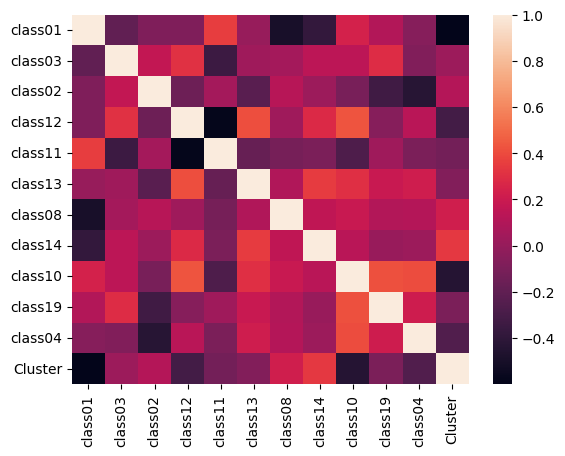

In [55]:
sns.heatmap(pls_test_scaled.corr())

### Clustering

In [14]:
pls_train_scaled, pls_test_scaled = helpers.KM_clustering(pls_train_scaled, pls_test_scaled, n_clusters=3)
#pls_train_scaled, pls_test_scaled = helpers.GMM_clustering(pls_train_scaled, pls_test_scaled, n_clusters=3)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# PCA

In [15]:
pc_train, pc_test = helpers.PCA_decomposition(x_train, x_test, y_train, y_test, n_components=20)

### Standardize

In [16]:
pc_train_scaled, pc_test_scaled = helpers.standardize(pc_train, pc_test)

<AxesSubplot: >

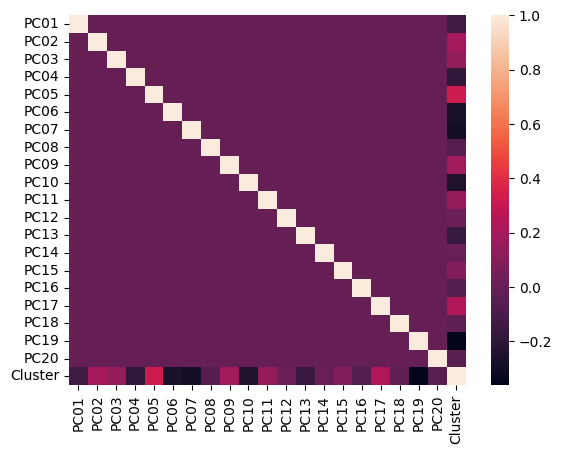

In [56]:
sns.heatmap(pc_train_scaled.corr())

<AxesSubplot: >

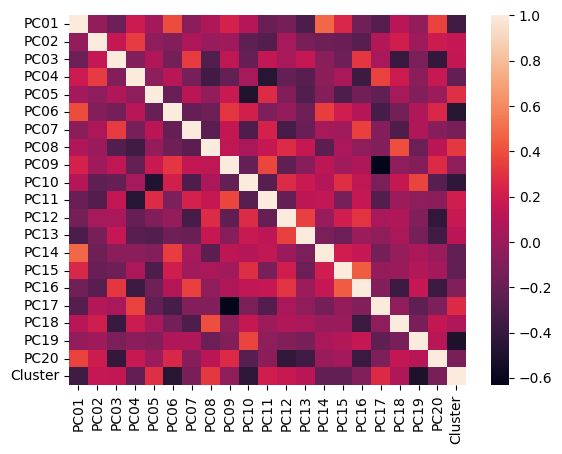

In [57]:
sns.heatmap(pc_test_scaled.corr())

### Clustering

In [17]:
pc_train_scaled, pc_test_scaled = helpers.KM_clustering(pc_train_scaled, pc_test_scaled, n_clusters=3)
#pc_train_scaled, pc_test_scaled = helpers.GMM_clustering(pc_train_scaled, pc_test_scaled, n_clusters=3)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Raw

<AxesSubplot: >

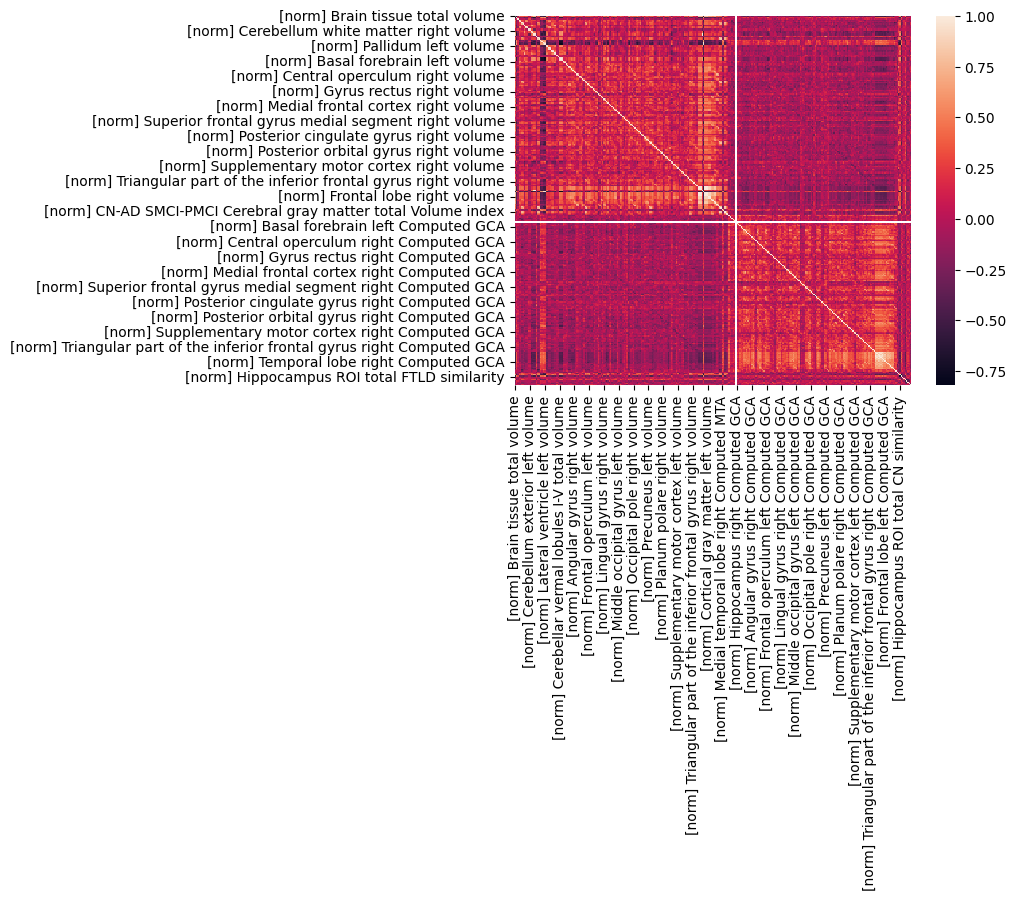

In [58]:
sns.heatmap(x_train.corr())

<AxesSubplot: >

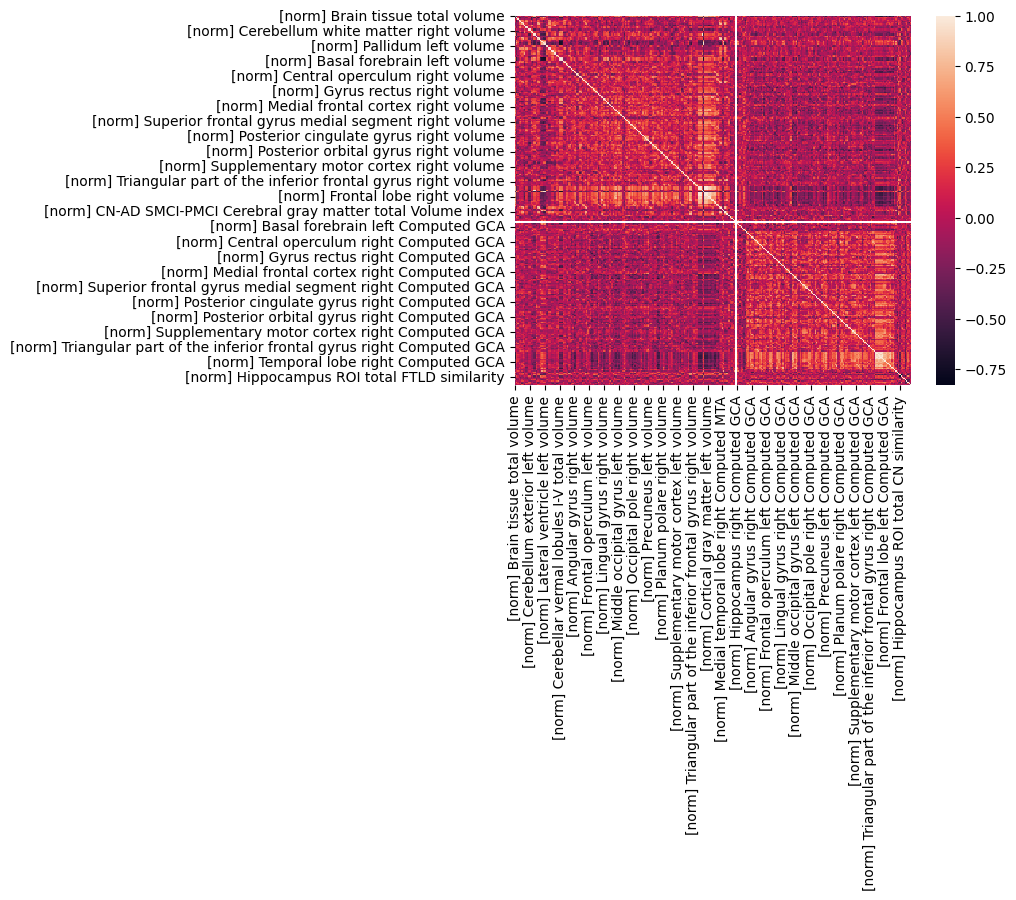

In [59]:
sns.heatmap(x_test.corr())

### Clustering

In [18]:
raw_train_scaled, raw_test_scaled = helpers.KM_clustering(x_train, x_test, n_clusters=3) 

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Lasso Feature Selection

In [19]:
# data1 : thr=0.2, data2 : thr=0
lasso_train, lasso_test = helpers.filter_lasso(x_train, x_test, y_train, threshold=0.2)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1561: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso picked 40 variables and eliminated the other 255 variables


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.130e-01
  model = cd_fast.enet_coordinate_descent(


<AxesSubplot: >

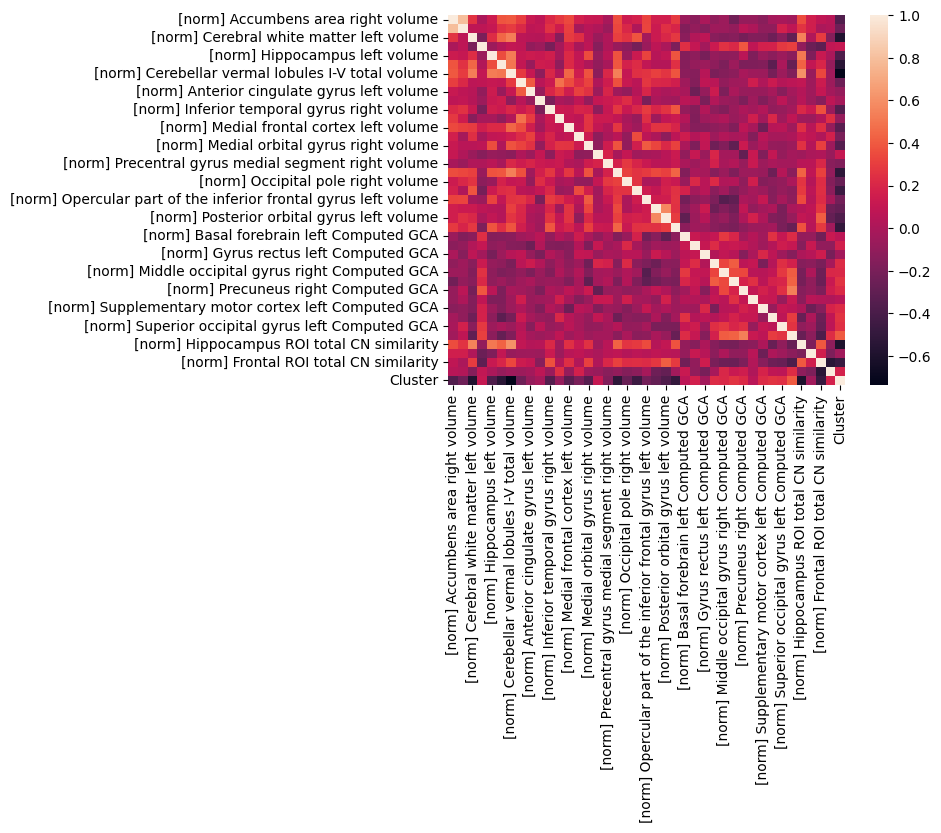

In [60]:
sns.heatmap(lasso_train.corr())

<AxesSubplot: >

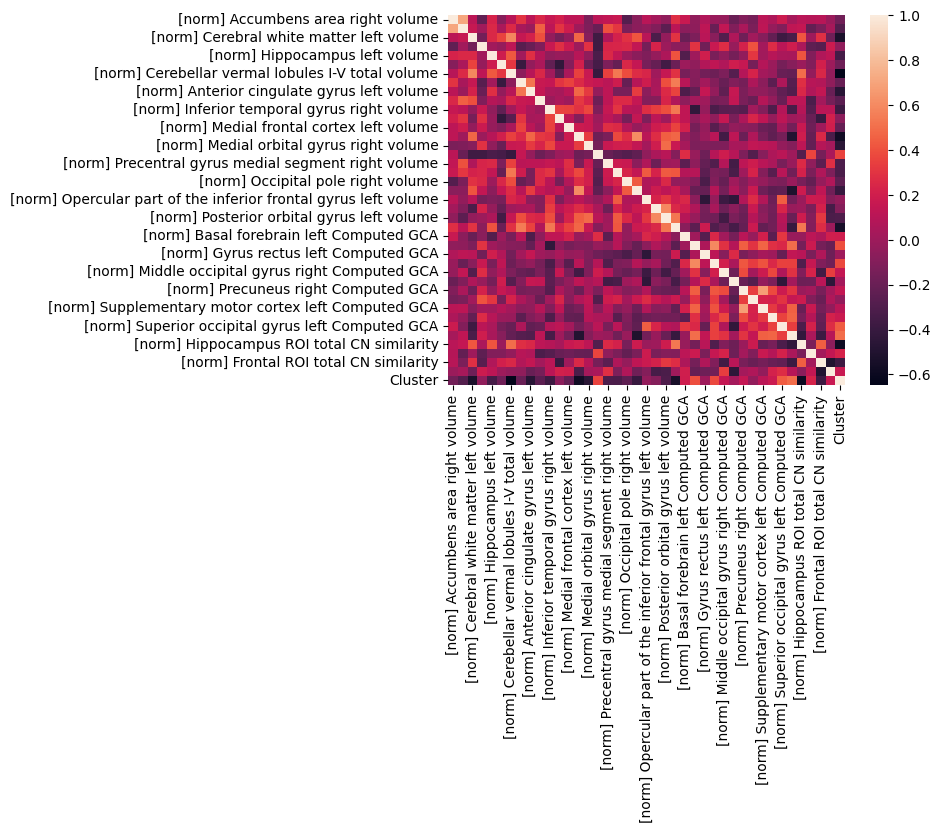

In [61]:
sns.heatmap(lasso_test.corr())

### Clustering

In [20]:
lasso_train, lasso_test = helpers.KM_clustering(lasso_train, lasso_test, n_clusters=3)
#lasso_train, lasso_test = helpers.GMM_clustering(lasso_train, lasso_test, n_clusters=2)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


C:\Users\anton\AppData\Local\Temp\ipykernel_2792\125740566.py:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(
C:\Users\anton\AppData\Local\Temp\ipykernel_2792\125740566.py:13: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(
C:\Users\anton\AppData\Local\Temp\ipykernel_2792\125740566.py:22: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(
C:\Users\anton\AppData\Local\Temp\ipykernel_2792\125740566.py:31: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(


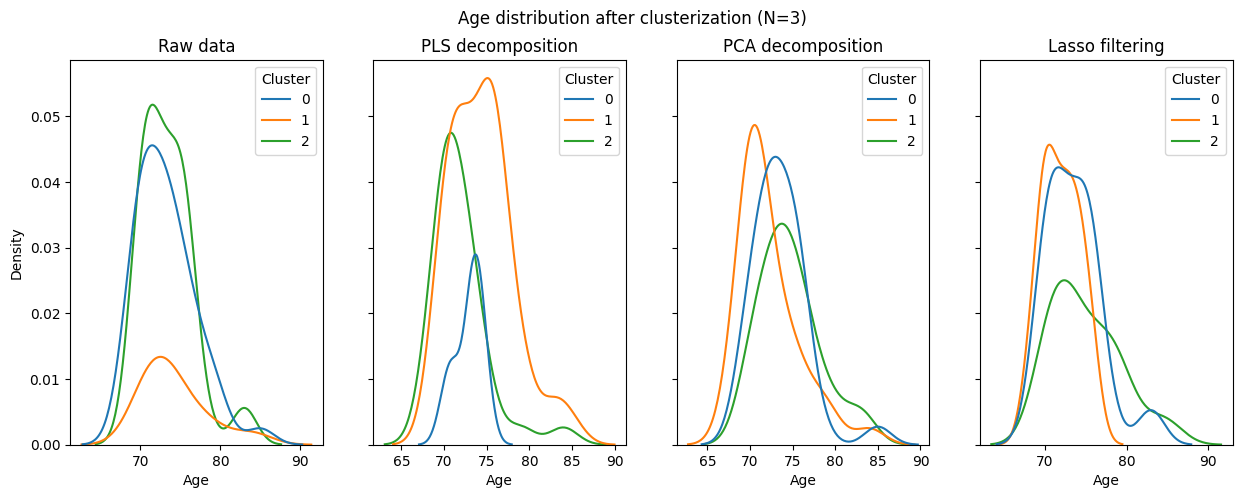

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Age distribution after clusterization (N=3)')

sns.kdeplot(
    pd.concat([y_train, raw_train_scaled], axis=1, join='inner'),
    x='Age',
    ax=axes[0],
    hue='Cluster',
    palette=sns.color_palette("tab10")
)
axes[0].set_title("Raw data")

sns.kdeplot(
    pd.concat([y_train, pls_train_scaled], axis=1, join='inner'),
    x='Age',
    ax=axes[1],
    hue='Cluster',
    palette=sns.color_palette("tab10")
)
axes[1].set_title("PLS decomposition")

sns.kdeplot(
    pd.concat([y_train, pc_train_scaled], axis=1, join='inner'),
    x='Age',
    ax=axes[2],
    hue='Cluster',
    palette=sns.color_palette("tab10")
)
axes[2].set_title("PCA decomposition")

sns.kdeplot(
    pd.concat([y_train, lasso_train], axis=1, join='inner'),
    x='Age',
    ax=axes[3],
    hue='Cluster',
    palette=sns.color_palette("tab10")
)
axes[3].set_title("Lasso filtering")


plt.show()

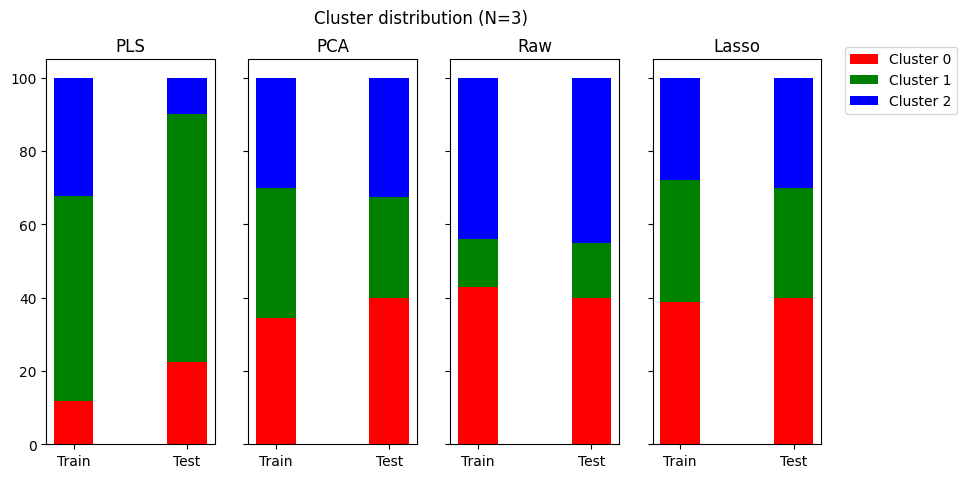

In [49]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharey=True)
fig.suptitle('Cluster distribution (N=3)')

labels = ['Train', 'Test']
width = 0.35

pls_cluster_0 = [
    (pls_train_scaled['Cluster'] == 0).sum()/pls_train_scaled.shape[0]*100,
    (pls_test_scaled['Cluster'] == 0).sum()/pls_test_scaled.shape[0]*100
]
pls_cluster_1 = [
    (pls_train_scaled['Cluster'] == 1).sum()/pls_train_scaled.shape[0]*100,
    (pls_test_scaled['Cluster'] == 1).sum()/pls_test_scaled.shape[0]*100
]
pls_cluster_2 = [
    (pls_train_scaled['Cluster'] == 2).sum()/pls_train_scaled.shape[0]*100,
    (pls_test_scaled['Cluster'] == 2).sum()/pls_test_scaled.shape[0]*100
]

axes[0].set_title("PLS")
axes[0].bar(labels, pls_cluster_0,width, label='Cluster 0', color='r')
axes[0].bar(labels, pls_cluster_1,width, bottom=pls_cluster_0,
       label='Cluster 1', color='g')
axes[0].bar(labels, pls_cluster_2,width, bottom= np.sum([pls_cluster_0, pls_cluster_1], axis=0),
       label='Cluster 2', color='b')

pca_cluster_0 = [
    (pc_train_scaled['Cluster'] == 0).sum()/pc_train_scaled.shape[0]*100,
    (pc_test_scaled['Cluster'] == 0).sum()/pc_test_scaled.shape[0]*100
]
pca_cluster_1 = [
    (pc_train_scaled['Cluster'] == 1).sum()/pc_train_scaled.shape[0]*100,
    (pc_test_scaled['Cluster'] == 1).sum()/pc_test_scaled.shape[0]*100
]
pca_cluster_2 = [
    (pc_train_scaled['Cluster'] == 2).sum()/pc_train_scaled.shape[0]*100,
    (pc_test_scaled['Cluster'] == 2).sum()/pc_test_scaled.shape[0]*100
]

axes[1].set_title("PCA")
axes[1].bar(labels, pca_cluster_0,width, label='Cluster 0', color='r')
axes[1].bar(labels, pca_cluster_1,width, bottom=pca_cluster_0,
       label='Cluster 1', color='g')
axes[1].bar(labels, pca_cluster_2,width, bottom= np.sum([pca_cluster_0, pca_cluster_1], axis=0),
       label='Cluster 2', color='b')

raw_cluster_0 = [
    (raw_train_scaled['Cluster'] == 0).sum()/raw_train_scaled.shape[0]*100,
    (raw_test_scaled['Cluster'] == 0).sum()/raw_test_scaled.shape[0]*100
]
raw_cluster_1 = [
    (raw_train_scaled['Cluster'] == 1).sum()/raw_train_scaled.shape[0]*100,
    (raw_test_scaled['Cluster'] == 1).sum()/raw_test_scaled.shape[0]*100
]
raw_cluster_2 = [
    (raw_train_scaled['Cluster'] == 2).sum()/raw_train_scaled.shape[0]*100,
    (raw_test_scaled['Cluster'] == 2).sum()/raw_test_scaled.shape[0]*100
]

axes[2].set_title("Raw")
axes[2].bar(labels, raw_cluster_0,width, label='Cluster 0', color='r')
axes[2].bar(labels, raw_cluster_1,width, bottom=raw_cluster_0,
       label='Cluster 1', color='g')
axes[2].bar(labels, raw_cluster_2,width, bottom= np.sum([raw_cluster_0, raw_cluster_1], axis=0),
       label='Cluster 2', color='b')

lasso_cluster_0 = [
    (lasso_train['Cluster'] == 0).sum()/lasso_train.shape[0]*100,
    (lasso_test['Cluster'] == 0).sum()/lasso_test.shape[0]*100
]
lasso_cluster_1 = [
    (lasso_train['Cluster'] == 1).sum()/lasso_train.shape[0]*100,
    (lasso_test['Cluster'] == 1).sum()/lasso_test.shape[0]*100
]
lasso_cluster_2 = [
    (lasso_train['Cluster'] == 2).sum()/lasso_train.shape[0]*100,
    (lasso_test['Cluster'] == 2).sum()/lasso_test.shape[0]*100
]

axes[3].set_title("Lasso")
axes[3].bar(labels, lasso_cluster_0,width, label='Cluster 0', color='r')
axes[3].bar(labels, lasso_cluster_1,width, bottom=lasso_cluster_0,
       label='Cluster 1', color='g')
axes[3].bar(labels, lasso_cluster_2,width, bottom= np.sum([lasso_cluster_0, lasso_cluster_1], axis=0),
       label='Cluster 2', color='b')

axes[3].legend(bbox_to_anchor=(1.1, 1.05))